## patch selection by image stats
#### much faster and more reliable than masking

In [11]:
import os
import sys
import time

import pandas as pd
import numpy as np

import openslide
from PIL.ImageStat import Stat

def accept_image(image_input, min_variance=100):
    V = Stat(image_input).var
    
    if np.array(V).max() < min_variance:
        return False
    else:
        return True

def get_image_stats(image_input):
    stats_dict = {}
    im_stat = Stat(image_input)
    stats_dict['extrema'] = im_stat.extrema
    stats_dict['count'] = im_stat.count
    stats_dict['sum'] = im_stat.sum
    stats_dict['sum2'] = im_stat.sum2
    stats_dict['mean'] = im_stat.mean
    stats_dict['median'] = im_stat.median
    stats_dict['rms'] = im_stat.rms
    stats_dict['var'] = im_stat.var
    stats_dict['stddev'] = im_stat.stddev
    
    return stats_dict

file_ext_list = ['.svs', '.tif', '.tiff']
def get_file_size_dict(data_dir, reverse_dict=False):
    """ Usage:
    file_size_dict = get_file_size_dict(data_dir)
    """
    file_size_dict = {}
    for f in os.listdir(data_dir):
        ff = os.path.join(data_dir, f)
        if os.path.isfile(ff): 
            _, f_ext = os.path.splitext(ff)
            if f_ext in file_ext_list:
                file_size_dict[ff] = os.path.getsize(ff)
                
    return file_size_dict

data_dir = '../../DigiPath_MLTK_data/Aperio'

file_size_dict = get_file_size_dict(data_dir)
rev_file_size_dict = {v:k for k, v in file_size_dict.items()}

ordered_keys = sorted(list(file_size_dict.values()))
files_list = []
for k in ordered_keys:
    files_list.append(rev_file_size_dict[k])

print('\nordered by size:\n')
count = 0
for f in files_list:
    _, f_only = os.path.split(f)
    print('%3i %30s: %i'%(count, f_only, file_size_dict[f]))
    count += 1


ordered by size:

  0         CMU-1-Small-Region.svs: 1938955
  1               JP2K-33003-1.svs: 63847265
  2           CMU-1-JP2K-33005.svs: 132565343
  3                      CMU-1.svs: 177552579
  4                      CMU-3.svs: 253815723
  5               JP2K-33003-2.svs: 289250433
  6                      CMU-2.svs: 390750635


In [2]:
svs_file_name = files_list[0] 
print(svs_file_name,'\n')
output_dir = '../../DigiPath_MLTK_data/module_test'
if os.path.isdir(output_dir) == False:
    print(output_dir, '\n\tnot found')
patch_height = 224
patch_width = 224
patch_size = [patch_height, patch_width]

openslide_obj = openslide.OpenSlide(svs_file_name)
print('obj.level_count', openslide_obj.level_count)
print('obj.dimensions', openslide_obj.dimensions)
print('obj.level_dimensions', openslide_obj.level_dimensions)
print('obj.level_downsamples', openslide_obj.level_downsamples)

"""
                            get two patches
"""
read_location_0 = (400,400)
test_sect_0 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_0)

read_location_1 = (1300,1200)
test_sect_1 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_1)

openslide_obj.close()

../../DigiPath_MLTK_data/Aperio/CMU-1-Small-Region.svs 

obj.level_count 1
obj.dimensions (2220, 2967)
obj.level_dimensions ((2220, 2967),)
obj.level_downsamples (1.0,)


		accept image =  False
patch location (400, 400) with variance per channel
[1.0745671600749602, 2.470426197600912, 1.674949255154221, 0.0]


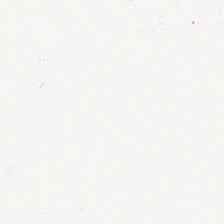

In [15]:
print('\t\taccept image = ', accept_image(test_sect_0))
print('patch location',read_location_0, 'with variance per channel')
print(Stat(test_sect_0).var)

display(test_sect_0)

		accept image =  True
patch location (1300, 1200) with variance per channel
[5616.320064622129, 7850.168795735376, 4949.017309205126, 0.0]


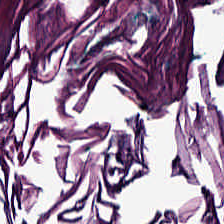

In [14]:
print('\t\taccept image = ', accept_image(test_sect_1))
print('patch location',read_location_1, 'with variance per channel')
print(Stat(test_sect_1).var)

display(test_sect_1)

In [16]:
ts_0_dict = get_image_stats(test_sect_0)
print('\t\t\tpatch location',read_location_0, 'stats dictionary:\n')
for k, v in ts_0_dict.items():
    print(k, v)
    
print('\n\n')

ts_1_dict = get_image_stats(test_sect_1)
print('\t\t\tpatch location',read_location_1, 'stats dictionary:\n')
for k, v in ts_1_dict.items():
    print(k, v)

			patch location (400, 400) stats dictionary:

extrema [(188, 255), (177, 255), (190, 255), (255, 255)]
count [50176, 50176, 50176, 50176]
sum [12332436.0, 12226201.0, 12220504.0, 12794880.0]
sum2 [3031163964.0, 2979237295.0, 2976421694.0, 3262694400.0]
mean [245.7835618622449, 243.6663145727041, 243.55277423469389, 255.0]
median [246, 243, 243, 255]
rms [245.785747855428, 243.67138380130234, 243.55621278602382, 255.0]
var [1.0745671600749602, 2.470426197600912, 1.674949255154221, 0.0]
stddev [1.0366133127039032, 1.5717589502213474, 1.2941983059617337, 0.0]



			patch location (1300, 1200) stats dictionary:

extrema [(0, 255), (0, 255), (0, 255), (255, 255)]
count [50176, 50176, 50176, 50176]
sum [8039137.0, 6775614.0, 8089145.0, 12794880.0]
sum2 [1569825117.0, 1308848318.0, 1552416815.0, 3262694400.0]
mean [160.21876992984693, 135.0369499362245, 161.21542171556123, 255.0]
median [163, 122, 161, 255]
rms [176.8795474396499, 161.50896768852738, 175.8960758747374, 255.0]
var [5616.3200